# Global Statistics

To accelerate the runtime, here we only load the first 100 samples from the previous `05a_inverse_global_opt.ipynb`.

In order to reproduce the results in our paper, use `df_test` (containing all 2500 samples).

## Import Module

In [4]:
import tensorflow as tf
import pandas as pd
import ast
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import pymiecs

## Set dynamic GPU memory growth

In [5]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


## Load runtime

In [6]:
with open("runtime/global_inverse_runtime.pkl", "rb") as f:
    loaded_runtimes = pickle.load(f)

loaded_runtimes.head()

,Sample,Runtime (seconds)
0,1,11.473748
1,2,11.250545
2,3,9.432516
3,4,12.056848
4,5,12.359925


In [7]:
# Sum the 'Runtime (seconds)' column
total_runtime = loaded_runtimes["Runtime (seconds)"].sum()
avr_runtime = loaded_runtimes["Runtime (seconds)"].mean()


print("Total Runtime (seconds):", total_runtime)
print("Total avr_runtime (seconds):", avr_runtime)

Total Runtime (seconds): 1080.0982673168182
Total avr_runtime (seconds): 10.800982673168182


## Load test data and best geometries from global opt

In [8]:
hdf5_df_file = "datasets/core_shell_particles_raw_122500_test_with_pred.h5"
df_test = pd.read_hdf(hdf5_df_file)
df_test.head()  # 2500 samples

with open("best_geometries/global_inverse_test_data.pkl", "rb") as f:
    best_df = pickle.load(f)

best_df.head()

,mat_core,mat_shell,r_core,r_shell,Sample Index,Runtime (seconds),Loss,mie_Qfwd,mie_Qback,predicted_Qfwd,predicted_Qback,log_Qfwd,log_Qback
0,Si3N4,Si,14.871198,128.592740,1,11.473748,0.111762,"[8.533829844460708, 9.340502075444443, 8.01940...","[0.8549934083899265, 0.18965925201335165, 0.28...","[9.796820640563965, 7.876668930053711, 7.01084...","[0.8263309001922607, 1.119938611984253, 0.9971...","[2.254846509388286, 2.3360684245208336, 2.1993...","[0.617881142624474, 0.1736669232735747, 0.2501..."
1,SiO2,Au,66.195253,86.872285,2,11.250545,0.006859,"[2.88995419429865, 2.7711695656998354, 2.65987...","[0.31796077742157647, 0.33129509976661764, 0.3...","[4.391070365905762, 3.927112579345703, 3.10570...","[0.9804540276527405, 1.3364711999893188, 1.031...","[1.3583973823164632, 1.3273851829772618, 1.297...","[0.27608567647329674, 0.28615222766072146, 0.2..."
2,TiO2,Si3N4,52.052082,30.654232,3,9.432516,0.000520,"[0.6381934643532078, 0.5824347586518034, 0.532...","[0.027964889052919984, 0.030175995877572713, 0...","[1.5704619884490967, 1.2410283088684082, 1.479...","[1.565356731414795, 1.3143272399902344, 1.7218...","[0.4935940885621718, 0.45896464742603416, 0.42...","[0.02758101183190901, 0.02972965742901675, 0.0..."
3,ZrO2,ZrO2,20.099041,113.858365,4,12.056848,0.000012,"[18.90946262780809, 15.986045111765787, 14.169...","[1.9714889761353533, 1.587385404767331, 1.3969...","[17.779001235961914, 13.255891799926758, 11.04...","[2.73857045173645, 2.626329183578491, 2.168610...","[2.991195127646979, 2.8323921311747187, 2.7192...","[1.0890631659524277, 0.9506478695981189, 0.874..."
4,Au,Si,72.353861,84.838776,5,12.359925,0.124807,"[3.428719735337389, 3.6685573523666233, 4.1377...","[0.8929630365246797, 0.8924259681667782, 0.984...","[5.033417224884033, 3.9798107147216797, 3.9398...","[1.1223475933074951, 1.3606879711151123, 0.999...","[1.4881105434936732, 1.5408501058329949, 1.636...","[0.6381433456364796, 0.6378595870262869, 0.685..."


## Statistics

In [9]:
# Convert relevant columns from DataFrame to NumPy arrays
qfwd_target = np.vstack(df_test["Q_fwd"])
qfwd_mie = np.vstack(best_df["mie_Qfwd"])

qback_target = np.vstack(df_test["Q_back"])
qback_mie = np.vstack(best_df["mie_Qback"])

# Calculate performance metrics
mse_Qfwd = np.abs(qfwd_target - qfwd_mie) ** 2
mae_Qfwd = np.abs(qfwd_target - qfwd_mie)

mse_Qback = np.abs(qback_target - qback_mie) ** 2
mae_Qback = np.abs(qback_target - qback_mie)

# Print the results
print(f"Inverse Design Performance for Qfwd:")
print(f"Mean Absolute Error (MAE): {mae_Qfwd.mean():.6f}")
print(f"Mean Squared Error (MSE): {mse_Qfwd.mean():.6f}")

print(f"\nTest Set Performance for Qback:")
print(f"Mean Absolute Error (MAE): {mae_Qback.mean():.6f}")
print(f"Mean Squared Error (MSE): {mse_Qback.mean():.6f}")

ValueError: operands could not be broadcast together with shapes (2500,64) (100,64) 

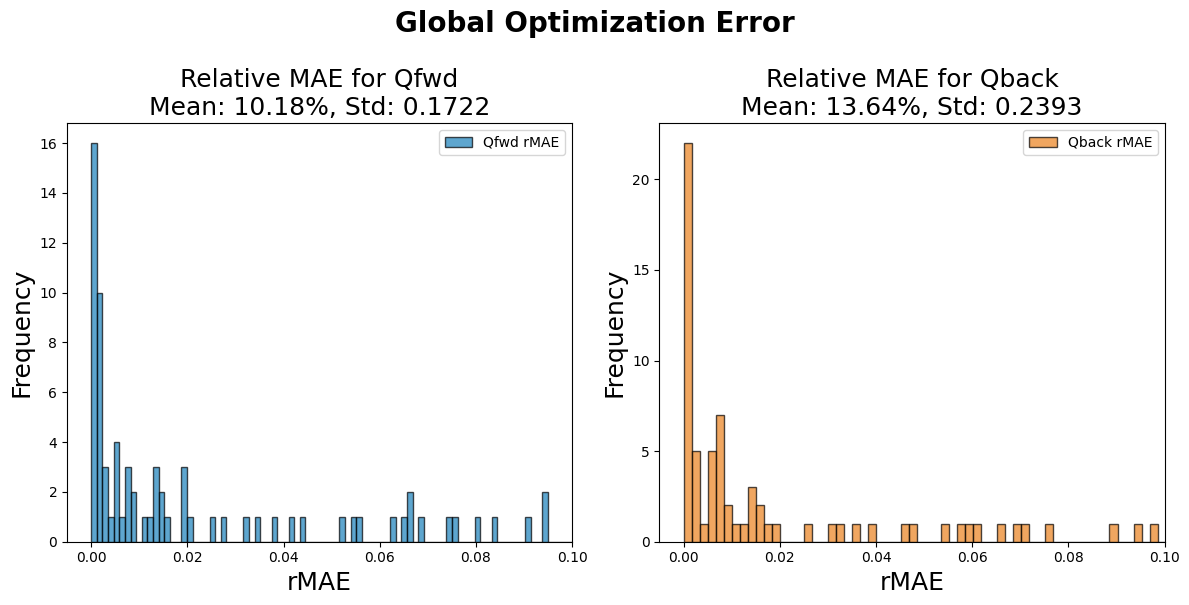

In [ ]:
# Absolute percentage error (MAPE)
mape_Qfwd = mae_Qfwd.mean(axis=1) / qfwd_target.mean()
mape_Qback = mae_Qback.mean(axis=1) / qback_target.mean()

# Plot histograms of MAE for Qfwd and Qback
plt.figure(figsize=(12, 6))
plt.suptitle("Global Optimization Error", fontweight="bold", fontsize=20, y=1.00)

# Plot the Qfwd MAE distribution
plt.subplot(1, 2, 1)
plt.hist(
    mape_Qfwd,
    bins=700,
    color="#1a80bbff",
    label="Qfwd rMAE",
    edgecolor="black",
    alpha=0.7,
)
plt.title(
    f"Relative MAE for Qfwd\nMean: {100*mape_Qfwd.mean():.2f}%, Std: {mape_Qfwd.std():.4f}",
    fontsize=18,
)
plt.xlabel("rMAE", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend()
plt.xlim([-0.005, 0.1])

# Plot the Qback MAE distribution
plt.subplot(1, 2, 2)
plt.hist(
    mape_Qback,
    bins=700,
    color="#ea801cff",
    label="Qback rMAE",
    edgecolor="black",
    alpha=0.7,
)
plt.title(
    f"Relative MAE for Qback\nMean: {100*mape_Qback.mean():.2f}%, Std: {mape_Qback.std():.4f}",
    fontsize=18,
)
plt.xlabel("rMAE", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend()
plt.xlim([-0.005, 0.1])

plt.tight_layout()
plt.show()

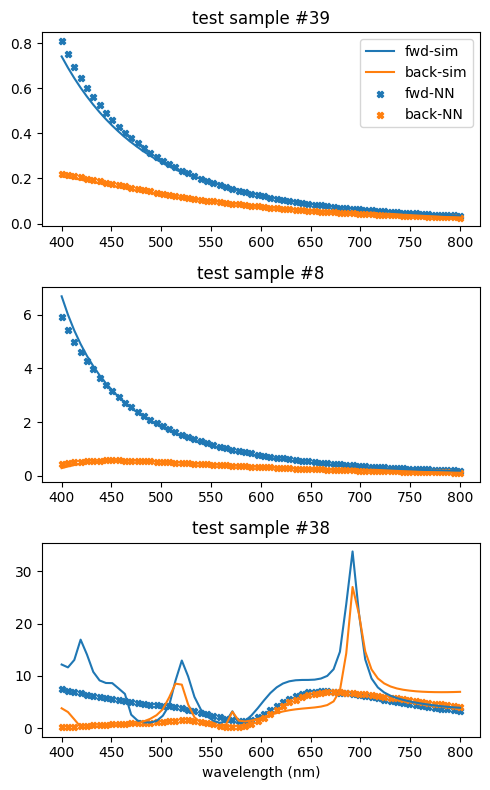

In [ ]:
plt.figure(figsize=(5, 8))
for i, d in enumerate(np.random.choice(len(df_test), 3)):
    plt.subplot(3, 1, i + 1, title=f"test sample #{d}")
    plt.plot(df_test["wavelength"][d], df_test["Q_fwd"][d], label="fwd-sim")
    plt.plot(df_test["wavelength"][d], df_test["Q_back"][d], label="back-sim")
    plt.scatter(
        df_test["wavelength"][d],
        best_df["mie_Qfwd"][d],
        label="fwd-NN",
        marker="X",
        s=20,
    )
    plt.scatter(
        df_test["wavelength"][d],
        best_df["mie_Qback"][d],
        label="back-NN",
        marker="X",
        s=20,
    )
    if i == 0:
        plt.legend()
    if i == 2:
        plt.xlabel("wavelength (nm)")

plt.tight_layout()
plt.show()